### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

### Define path and load data

In [2]:
# Define paths to local files
file_paths = {
    "TSLA": "../data/TSLA_proccessed_data.csv",
    "SPY": "../data/SPY_proccessed_data.csv",
    "BND": "../data/BND_proccessed_data.csv"
}

# Load data function
def load_data(file_path):
    return pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Load all datasets into a dictionary
data_dict = {ticker: load_data(path) for ticker, path in file_paths.items()}


In [3]:
def preprocess_data(data):
    # Ensure 'Adj Close' column is numeric (convert if necessary)
    data['Adj Close'] = pd.to_numeric(data['Adj Close'], errors='coerce')
    
    # Basic data cleaning and feature engineering
    data['Return'] = data['Adj Close'].pct_change()
    data['Volatility'] = data['Return'].rolling(window=30).std()
    data['Rolling_Mean'] = data['Adj Close'].rolling(window=30).mean()
    
    # Lag features
    lags=[1, 2, 3]
    for lag in lags:
        data[f'Lag_{lag}'] = data['Adj Close'].shift(lag)
        
    # Drop NA rows from rolling and lagged features
    data.dropna(inplace=True)
    data= data.sort_index()
    return data

In [4]:
# Perform the Augmented Dickey-Fuller test for stationarity
def check_stationarity(data, column='Adj Close'):
    result = adfuller(data[column])
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")
    print("\n")

In [5]:
# LSTM Data Preparation Function
def prepare_lstm_data(series, n_lags=60):
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(n_lags, len(series_scaled)):
        X.append(series_scaled[i - n_lags:i])
        y.append(series_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    
    return X, y, scaler

In [6]:
from joblib import dump
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

def train_arima_models(data, dataset_name):
    """
    Train ARIMA and SARIMA models and save them to disk.

    Args:
        data (pd.DataFrame): DataFrame containing the time series data with 'Adj Close'.
        dataset_name (str): Unique name for the dataset to save models (e.g., "dataset1").

    Returns:
        tuple: ARIMA forecast, SARIMA forecast, and test set.
    """
    # Ensure Date column is datetime and set it as the index
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    
    # Select 'Adj Close' for forecasting
    data_series = data['Adj Close']
    
    # Split data into train and test sets (e.g., 80% train, 20% test)
    train_size = int(len(data_series) * 0.8)
    train, test = data_series[:train_size], data_series[train_size:]
    
    # Train ARIMA model
    arima_model = auto_arima(train, seasonal=False, trace=True)
    arima_forecast = arima_model.predict(n_periods=len(test))
    
    # Save ARIMA model
    arima_filename = f"arima_model_{dataset_name}.joblib"
    dump(arima_model, arima_filename)
    print(f"ARIMA model saved as {arima_filename}")
    
    # Train SARIMA model
    sarima_model = SARIMAX(train, order=arima_model.order, seasonal_order=(1, 1, 1, 12))
    sarima_result = sarima_model.fit(disp=False)
    sarima_forecast = sarima_result.forecast(len(test))
    
    # Save SARIMA model
    sarima_filename = f"sarima_model_{dataset_name}.pkl"
    sarima_result.save(sarima_filename)
    print(f"SARIMA model saved as {sarima_filename}")
    
    # Calculate evaluation metrics for ARIMA
    arima_mae = mean_absolute_error(test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
    arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

    # Calculate evaluation metrics for SARIMA
    sarima_mae = mean_absolute_error(test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
    sarima_mape = np.mean(np.abs((test - sarima_forecast) / test)) * 100

    # Print results
    print(f"ARIMA MAE: {arima_mae:.4f}")
    print(f"ARIMA RMSE: {arima_rmse:.4f}")
    print(f"ARIMA MAPE: {arima_mape:.2f}%")
    
    print(f"SARIMA MAE: {sarima_mae:.4f}")
    print(f"SARIMA RMSE: {sarima_rmse:.4f}")
    print(f"SARIMA MAPE: {sarima_mape:.2f}%")
    
    return arima_forecast, sarima_forecast, test


In [7]:
# Define the PyTorch LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

In [8]:
# Train LSTM Model in PyTorch
def train_lstm_model(data, n_lags=60, epochs=50, batch_size=16, lr=0.001):
    X, y, scaler = prepare_lstm_data(data['Adj Close'], n_lags=n_lags)
    
    X_train, y_train = X[:int(0.8*len(X))], y[:int(0.8*len(y))]
    X_test, y_test = X[int(0.8*len(X)):], y[int(0.8*len(y)):]

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMModel()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))
            loss.backward()
            optimizer.step()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
    
    # Evaluate on test set
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            predictions.extend(output.numpy())
            actuals.extend(y_batch.numpy())

    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals_rescaled = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    lstm_mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
    lstm_rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
    lstm_mape = np.mean(np.abs((actuals_rescaled - predictions_rescaled) / actuals_rescaled)) * 100

    print(f"LSTM MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}, MAPE: {lstm_mape:.2f}%\n")
    
    
    # lstm_forecast = model(X_test).detach().numpy()
    return predictions_rescaled, actuals_rescaled, model


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_forecasts(test, arima_forecast, sarima_forecast, lstm_forecast, title):
    # Ensure forecasts have the same length
    forecast_length = len(test)
    
    # Truncate or pad the forecasts to match the test length
    if len(lstm_forecast) > forecast_length:
        lstm_forecast = lstm_forecast[:forecast_length]
    elif len(lstm_forecast) < forecast_length:
        lstm_forecast = np.pad(lstm_forecast, (0, forecast_length - len(lstm_forecast)), mode='constant', constant_values=np.nan)

    # Plot the actual vs forecasted values for each model
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test.values, label="Actual", color="black")  # actual values
    plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="blue")
    plt.plot(test.index, sarima_forecast, label="SARIMA Forecast", color="green")
    plt.plot(test.index, lstm_forecast, label="LSTM Forecast", color="red")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


Processing TSLA data:
ADF Statistic: -1.1631
p-value: 0.6892
Critical Values:
   1%: -3.4331
   5%: -2.8627
   10%: -2.5674
The series is non-stationary.


Training ARIMA and SARIMA models for TSLA data:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12229.107, Time=2.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12225.035, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12223.669, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12223.765, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12223.518, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12225.107, Time=1.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.547 seconds
ARIMA model saved as arima_model_TSLA.joblib


c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will

SARIMA model saved as sarima_model_TSLA.pkl
ARIMA MAE: 36.6519
ARIMA RMSE: 46.1460
ARIMA MAPE: nan%
SARIMA MAE: 31.2217
SARIMA RMSE: 38.1622
SARIMA MAPE: nan%
Training LSTM model for TSLA data:


C:\Users\elbet\AppData\Local\Temp\ipykernel_7884\3173432171.py:48: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100
C:\Users\elbet\AppData\Local\Temp\ipykernel_7884\3173432171.py:53: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  sarima_mape = np.mean(np.abs((test - sarima_forecast) / test)) * 100


Epoch 1/50, Loss: 0.0055
Epoch 11/50, Loss: 0.0004
Epoch 21/50, Loss: 0.0013
Epoch 31/50, Loss: 0.0001
Epoch 41/50, Loss: 0.0000
LSTM MAE: 5.6091, RMSE: 7.7664, MAPE: 2.74%

LSTM model for TSLA saved at TSLA_lstm_model.pth
Plotting forecast vs actual for TSLA data:


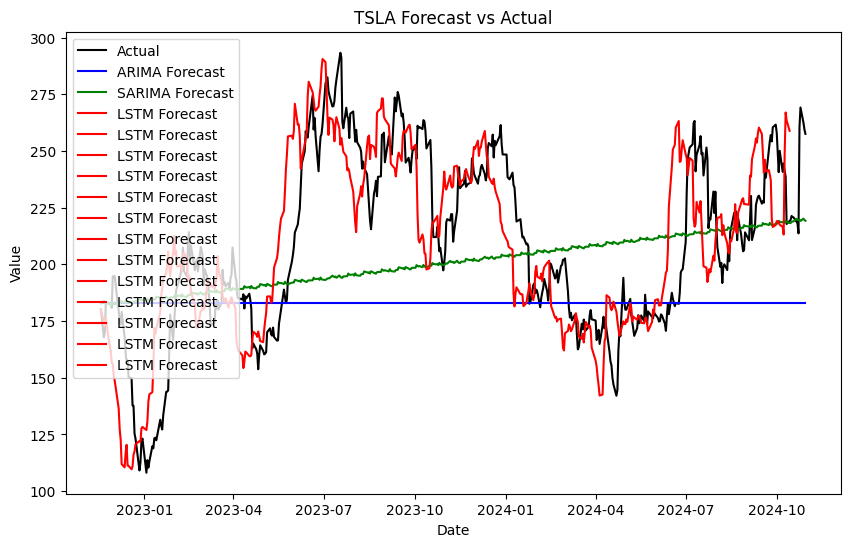



Processing SPY data:
ADF Statistic: 0.9769
p-value: 0.9940
Critical Values:
   1%: -3.4331
   5%: -2.8627
   10%: -2.5674
The series is non-stationary.


Training ARIMA and SARIMA models for SPY data:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10269.303, Time=4.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10361.403, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10344.202, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10345.967, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10361.250, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10343.634, Time=1.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10343.936, Time=1.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10332.855, Time=4.88 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10338.361, Time=6.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10343.219, Time=0.71 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10344.234, Time=1.93 sec
 ARIMA(3,1,1)(0,0

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will

SARIMA model saved as sarima_model_SPY.pkl
ARIMA MAE: 57.5132
ARIMA RMSE: 74.0011
ARIMA MAPE: nan%
SARIMA MAE: 57.3474
SARIMA RMSE: 73.8409
SARIMA MAPE: nan%
Training LSTM model for SPY data:


C:\Users\elbet\AppData\Local\Temp\ipykernel_7884\3173432171.py:48: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100
C:\Users\elbet\AppData\Local\Temp\ipykernel_7884\3173432171.py:53: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  sarima_mape = np.mean(np.abs((test - sarima_forecast) / test)) * 100


Epoch 1/50, Loss: 0.0004
Epoch 11/50, Loss: 0.0006
Epoch 21/50, Loss: 0.0000
Epoch 31/50, Loss: 0.0003
Epoch 41/50, Loss: 0.0001
LSTM MAE: 3.5683, RMSE: 4.4900, MAPE: 0.77%

LSTM model for SPY saved at SPY_lstm_model.pth
Plotting forecast vs actual for SPY data:


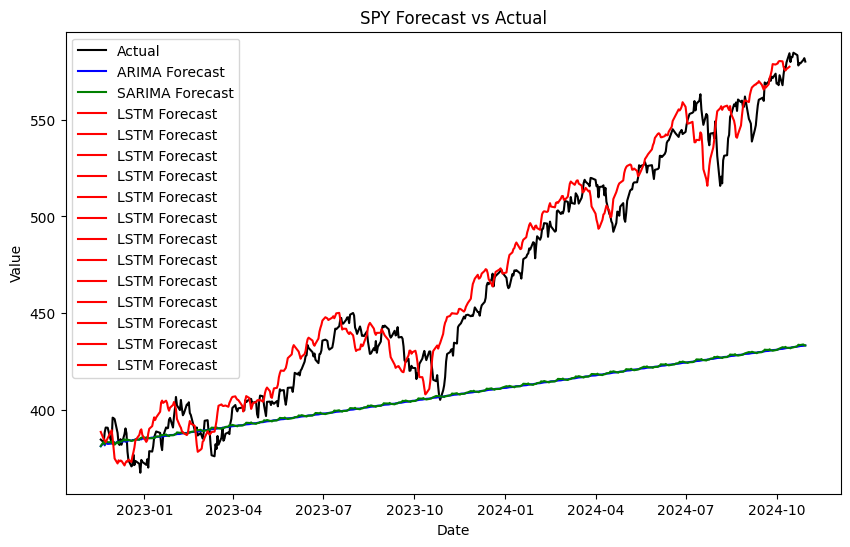



Processing BND data:
ADF Statistic: -1.4608
p-value: 0.5528
Critical Values:
   1%: -3.4331
   5%: -2.8627
   10%: -2.5674
The series is non-stationary.


Training ARIMA and SARIMA models for BND data:
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.68 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1183.442, Time=0.23 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=760.181, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1181.443, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=505.931, Time=1.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=291.901, Time=1.09 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=144.295, Time=0.89 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=92.117, Time=1.04 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-168.824, Time=5.79 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-163.411, Time=4.62 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=i

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will

SARIMA model saved as sarima_model_BND.pkl
ARIMA MAE: 7.8008
ARIMA RMSE: 9.2216
ARIMA MAPE: nan%
SARIMA MAE: 11.2418
SARIMA RMSE: 13.0877
SARIMA MAPE: nan%
Training LSTM model for BND data:


C:\Users\elbet\AppData\Local\Temp\ipykernel_7884\3173432171.py:48: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100
C:\Users\elbet\AppData\Local\Temp\ipykernel_7884\3173432171.py:53: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  sarima_mape = np.mean(np.abs((test - sarima_forecast) / test)) * 100


Epoch 1/50, Loss: 0.0043
Epoch 11/50, Loss: 0.0011
Epoch 21/50, Loss: 0.0002
Epoch 31/50, Loss: 0.0000
Epoch 41/50, Loss: 0.0003
LSTM MAE: 0.2666, RMSE: 0.3330, MAPE: 0.38%

LSTM model for BND saved at BND_lstm_model.pth
Plotting forecast vs actual for BND data:


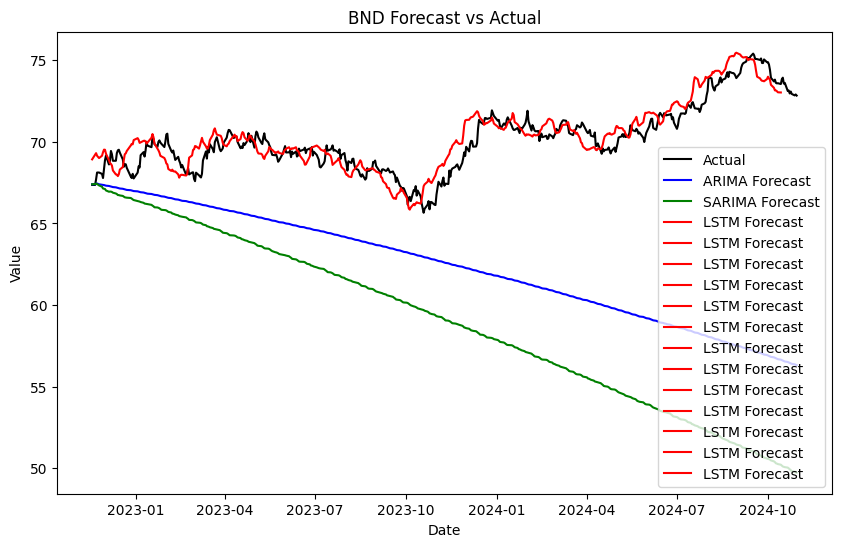

In [10]:
import torch

# Main execution 
for ticker, data in data_dict.items():
    print(f'Processing {ticker} data:')
    data_dict[ticker] = preprocess_data(data)
    check_stationarity(data_dict[ticker])

    # Train and evaluate ARIMA and SARIMA models
    print(f"Training ARIMA and SARIMA models for {ticker} data:")
    arima_forecast, sarima_forecast, test_data = train_arima_models(data_dict[ticker], dataset_name=ticker)

    # Train and evaluate LSTM model
    print(f"Training LSTM model for {ticker} data:")
    lstm_forecast, lstm_test, lstm_model = train_lstm_model(data_dict[ticker])

    # Save the LSTM model
    model_save_path = f'{ticker}_lstm_model.pth'
    torch.save(lstm_model.state_dict(), model_save_path)
    print(f"LSTM model for {ticker} saved at {model_save_path}")

    # Plot the forecasts from ARIMA, SARIMA, and LSTM models
    print(f"Plotting forecast vs actual for {ticker} data:")
    plot_forecasts(test_data, arima_forecast, sarima_forecast, lstm_forecast, title=f'{ticker} Forecast vs Actual')
    print("\n")
